In [15]:
# Import libraries 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import tensorflow as tf 
np.random.seed(42)#for reproducibility 


2023-09-30 01:50:43.087264: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-30 01:50:43.405077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-30 01:50:47.239793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


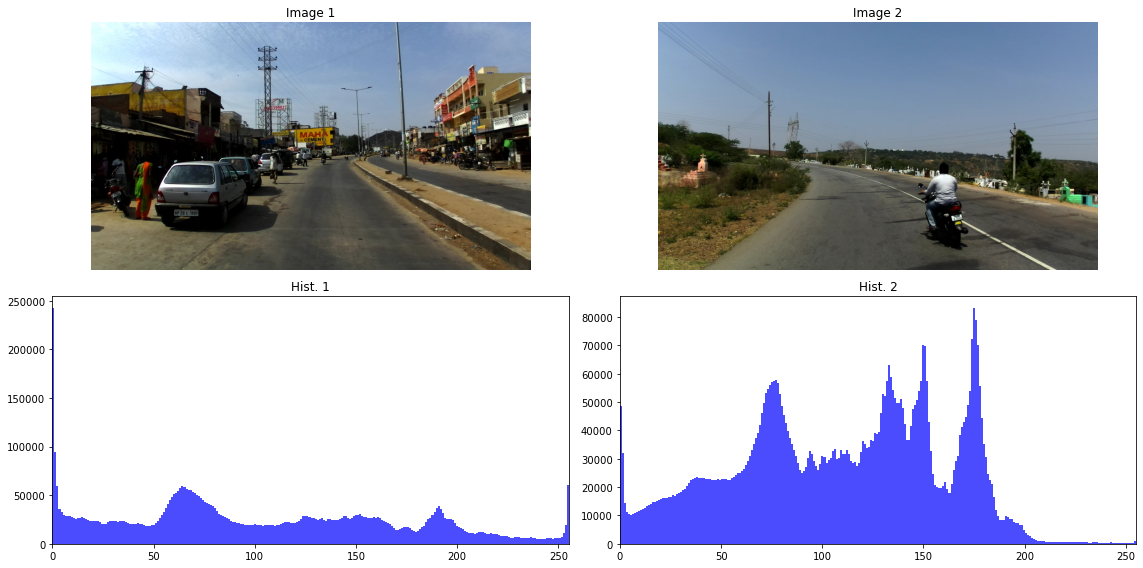

In [16]:
#showing the histogram plots of the image 
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
image_paths =[
    '/data2/grp03/dataset/idd20kII/leftImg8bit/train/201/frame0029_leftImg8bit.jpg',
    '/data2/grp03/dataset/idd20kII/leftImg8bit/val/205/frame0340_leftImg8bit.jpg'
]
# Iterate over image paths and plot each image and its histogram
for i, (image_path, ax) in enumerate(zip(image_paths, axes[0])):
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')

    # Plot histogram for the image
    ax_hist = axes[1, i]
    ax_hist.hist(img.ravel(), bins=256, color='blue', alpha=0.7)
    ax_hist.set_title(f'Hist. {i + 1}')
    ax_hist.set_xlim(0, 255)

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.savefig('/data2/grp03/results/Original_Image_Hist.png')
plt.show()


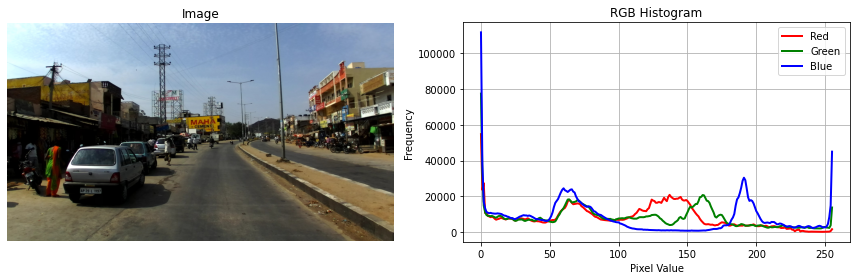

In [17]:
#Plotting the RGB contents in the image 

image_path = '/data2/grp03/dataset/idd20kII/leftImg8bit/train/201/frame0029_leftImg8bit.jpg'

# Load the image
image = cv2.imread(image_path)

# Convert the image from BGR to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Calculate the histogram for each channel (R, G, and B)
hist_r = cv2.calcHist([image_rgb], [0], None, [256], [0, 256])
hist_g = cv2.calcHist([image_rgb], [1], None, [256], [0, 256])
hist_b = cv2.calcHist([image_rgb], [2], None, [256], [0, 256])

# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the image on the left subplot
axes[0].imshow(image_rgb)
axes[0].set_title('Image')
axes[0].axis('off')

# Plot the RGB histograms on the right subplot
axes[1].plot(hist_r, color='red', label='Red', linewidth=2)
axes[1].plot(hist_g, color='green', label='Green', linewidth=2)
axes[1].plot(hist_b, color='blue', label='Blue', linewidth=2)
axes[1].set_title('RGB Histogram')
axes[1].set_xlabel('Pixel Value')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Show the plot
plt.tight_layout()
plt.grid(True)
plt.savefig("/data2/grp03/results/rgb_content_original_image.png")
plt.show()


In [34]:
import json
from PIL import Image, ImageDraw

#path to json file 
path = '/data2/grp03/dataset/idd20kII/gtFine/val/205/frame0340_gtFine_polygons.json'
with open(path, 'r') as json_file:
    data = json.load(json_file)


image_path = '/data2/grp03/dataset/idd20kII/leftImg8bit/val/205/frame0340_leftImg8bit.jpg'
image = Image.open(image_path)

# Create a blank mask with the same dimensions as the image
mask = Image.new('1', image.size, 0)
draw = ImageDraw.Draw(mask)

# Iterate through annotations and extract vegetation polygons
# The data points of polygon are stored in a list under the dictionary
for obj in data['objects']:
    if obj['label'] == 'vegetation':
        polygon_points = obj['polygon']
        if polygon_points:
            polygon_tuples = [(x, y) for x, y in polygon_points]
            draw.polygon(polygon_tuples, outline=1, fill=1)
    
vegetation_image = Image.new('RGB', image.size)
vegetation_image.paste(image, mask=mask)
vegetation_image.save('/data2/grp03/sample_extraction.jpg')

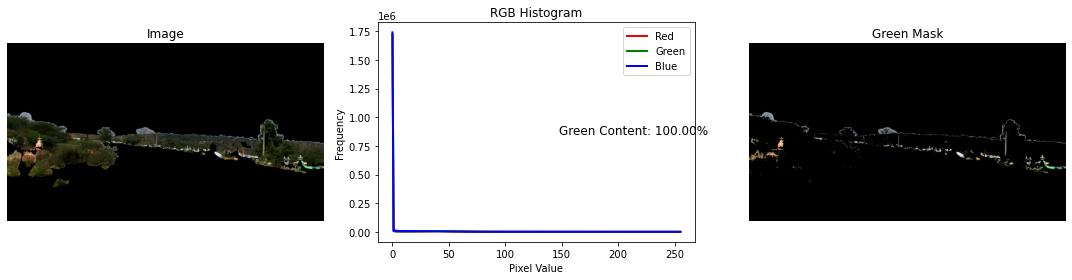

In [30]:
#From the mask we have created we can make an assumption if the marks are segregating vegetation area correctly by finding the green content in the image 
#If the green content is high it is safe to assume that the particular image has good amount of vegetation in it 
#Plotting the RGB contents in the image 

# Image path
image_path = '/data2/grp03/sample_extraction.jpg'

# Load the image
image = cv2.imread(image_path)

# Convert the image from BGR to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Calculate the histogram for each channel (R, G, and B)
hist_r = cv2.calcHist([image_rgb], [0], None, [256], [0, 256])
hist_g = cv2.calcHist([image_rgb], [1], None, [256], [0, 256])
hist_b = cv2.calcHist([image_rgb], [2], None, [256], [0, 256])

# Calculate the total number of pixels
total_pixels = image_rgb.shape[0] * image_rgb.shape[1]

# Calculate the percentage of green content
percentage_green = (hist_g.sum() / total_pixels) * 100

# Create a figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot the image on the left subplot
axes[0].imshow(image_rgb)
axes[0].set_title('Image')
axes[0].axis('off')

# Plot the RGB histograms on the middle subplot
axes[1].plot(hist_r, color='red', label='Red', linewidth=2)
axes[1].plot(hist_g, color='green', label='Green', linewidth=2)
axes[1].plot(hist_b, color='blue', label='Blue', linewidth=2)
axes[1].set_title('RGB Histogram')
axes[1].set_xlabel('Pixel Value')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Create a binary mask for the green channel
green_mask = (image_rgb[:, :, 1] > 100)  # Adjust the threshold as needed
masked_image = np.copy(image_rgb)
masked_image[~green_mask] = [0, 0, 0]

# Overlay the green mask on the right subplot
axes[2].imshow(masked_image)
axes[2].set_title('Green Mask')
axes[2].axis('off')

# Show the plot and the green content percentage
plt.tight_layout()
plt.grid(True)
plt.figtext(0.59, 0.52, f'Green Content: {percentage_green:.2f}%', ha='center', fontsize=12)
plt.savefig('/data2/grp03/results/green_mask_green_content.png')
plt.show()


**The above image has segregated the greent content very well**

In [41]:
path1 = '/data2/grp03/dataset/idd20kII/gtFine/gtFine/train'
path2 = '/data2/grp03/dataset/idd20kII/leftImg8bit/train'
dir = os.listdir(path2)
print(dir)

['306', '356', '283', '423', '331', '353', '277', '237', '455', '460', '382', '273', '483', '235', '449', '357', '444', '534', '508', '369', '458', '361', '490', '247', '246', '499', '456', '430', '560', '573', '409', '522', '424', '288', '468', '218', '528', '313', '307', '326', '301', '374', '575', '303', '219', '441', '248', '496', '501', '263', '400', '473', '239', '282', '224', '577', '537', '437', '371', '517', '503', '245', '231', '413', '236', '477', '377', '310', '267', '241', '380', '350', '401', '494', '561', '482', '299', '252', '454', '547', '359', '211', '225', '203', '238', '302', '352', '446', '220', '403', '434', '368', '457', '426', '315', '204', '333', '428', '429', '512', '564', '411', '527', '554', '216', '370', '314', '410', '443', '367', '340', '466', '571', '551', '462', '298', '293', '214', '538', '489', '266', '309', '355', '544', '506', '498', '469', '467', '321', '417', '201', '339', '419', '387', '358', '550', '209', '317', '495', '327', '541', '431', '488'

**Training Masking**

In [45]:
from tqdm import tqdm

# paths to json and image files
json_base_path = '/data2/grp03/dataset/idd20kII/gtFine/train'
image_base_path = '/data2/grp03/dataset/idd20kII/leftImg8bit/train'
output_base_path = '/data2/grp03/dataset/idd20kII/mask/train'  # path to where the mask files are stored

# List of common subfolders
common_subfolders = os.listdir(json_base_path)

for subfolder in common_subfolders:
    # Collecting the JSON files
    json_folder_path = os.path.join(json_base_path, subfolder)

    # Path to corresponding image folder
    image_folder_path = os.path.join(image_base_path, subfolder)

    # Making subdirectories for the masks of images in subfolders
    output_folder_path = os.path.join(output_base_path, subfolder)
    os.makedirs(output_folder_path, exist_ok=True)

    # Collecting JSON and image files
    json_files = [f for f in os.listdir(json_folder_path) if f.endswith('_gtFine_polygons.json')]
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('_leftImg8bit.jpg')]

    # progress bar
    progress_bar = tqdm(total=len(json_files), desc=f'Subfolder: {subfolder}', unit='file', ncols=100)

    # Iterating through JSON files and creating masks
    for json_file in json_files:
        # Extracting the respective image file name from the JSON file name
        image_file_name = json_file.replace('_gtFine_polygons.json', '_leftImg8bit.jpg')
        if image_file_name in image_files:
            # Now follow the same procedure used to create the mask earlier
            with open(os.path.join(json_folder_path, json_file), 'r') as json_file:
                data = json.load(json_file)

            # Load the corresponding image
            image_path = os.path.join(image_folder_path, image_file_name)
            image = Image.open(image_path)
            mask = Image.new('1', image.size, 0)
            draw = ImageDraw.Draw(mask)

            # Iterating through annotations and extracting the vegetation polygons
            for obj in data['objects']:
                if obj['label'] == 'vegetation':
                    polygon_points = obj['polygon']
                    if polygon_points:
                        # Convert the list of polygon points to a list of tuples
                        polygon_tuples = [(x, y) for x, y in polygon_points]
                        draw.polygon(polygon_tuples, outline=1, fill=1)

            # Overlap mask on the image to extract the vegetation
            vegetation_image = Image.new('RGB', image.size)
            vegetation_image.paste(image, mask=mask)

            # Save the extracted vegetation image as a mask
            mask_file_name = image_file_name.replace('_leftImg8bit.jpg', '_mask.png')
            mask_path = os.path.join(output_folder_path, mask_file_name)
            vegetation_image.save(mask_path)

            # Updating the progress bar
            progress_bar.update()

    # Close the progress bar for this subfolder
    progress_bar.close()
    print("****************************Process complete****************************")
    print(f"Total {len(json_files)} masks made and stored under the directory {output_folder_path}")


Subfolder: 306: 100%|█████████████████████████████████████████████| 52/52 [00:28<00:00,  1.84file/s]


****************************Process complete****************************
Total 52 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/306


Subfolder: 356: 100%|█████████████████████████████████████████████| 70/70 [00:56<00:00,  1.23file/s]


****************************Process complete****************************
Total 70 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/356


Subfolder: 283: 100%|█████████████████████████████████████████████| 60/60 [01:04<00:00,  1.08s/file]


****************************Process complete****************************
Total 60 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/283


Subfolder: 423: 100%|███████████████████████████████████████████████| 9/9 [00:09<00:00,  1.10s/file]


****************************Process complete****************************
Total 9 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/423


Subfolder: 331: 100%|███████████████████████████████████████████████| 9/9 [00:12<00:00,  1.34s/file]


****************************Process complete****************************
Total 9 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/331


Subfolder: 353: 100%|█████████████████████████████████████████████| 19/19 [00:11<00:00,  1.69file/s]


****************************Process complete****************************
Total 19 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/353


Subfolder: 277: 100%|█████████████████████████████████████████████| 63/63 [00:47<00:00,  1.34file/s]


****************************Process complete****************************
Total 63 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/277


Subfolder: 237: 100%|███████████████████████████████████████████| 160/160 [01:33<00:00,  1.70file/s]


****************************Process complete****************************
Total 160 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/237


Subfolder: 455: 100%|███████████████████████████████████████████████| 2/2 [00:01<00:00,  1.27file/s]


****************************Process complete****************************
Total 2 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/455


Subfolder: 460: 100%|███████████████████████████████████████████| 197/197 [02:07<00:00,  1.55file/s]


****************************Process complete****************************
Total 197 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/460


Subfolder: 382: 100%|███████████████████████████████████████████████| 3/3 [00:02<00:00,  1.34file/s]


****************************Process complete****************************
Total 3 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/382


Subfolder: 273: 100%|█████████████████████████████████████████████| 15/15 [00:10<00:00,  1.40file/s]


****************************Process complete****************************
Total 15 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/273


Subfolder: 483: 100%|███████████████████████████████████████████| 106/106 [01:31<00:00,  1.16file/s]


****************************Process complete****************************
Total 106 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/483


Subfolder: 235: 100%|█████████████████████████████████████████████| 51/51 [00:44<00:00,  1.14file/s]


****************************Process complete****************************
Total 51 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/235


Subfolder: 449: 100%|█████████████████████████████████████████████| 17/17 [00:11<00:00,  1.44file/s]


****************************Process complete****************************
Total 17 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/449


Subfolder: 357: 100%|█████████████████████████████████████████████| 90/90 [01:32<00:00,  1.03s/file]


****************************Process complete****************************
Total 90 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/357


Subfolder: 444: 100%|███████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14file/s]


****************************Process complete****************************
Total 3 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/444


Subfolder: 534: 100%|███████████████████████████████████████████████| 4/4 [00:04<00:00,  1.10s/file]


****************************Process complete****************************
Total 4 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/534


Subfolder: 508: 100%|█████████████████████████████████████████████| 35/35 [00:35<00:00,  1.03s/file]


****************************Process complete****************************
Total 35 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/508


Subfolder: 369: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16file/s]


****************************Process complete****************************
Total 1 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/369


Subfolder: 458: 100%|███████████████████████████████████████████████| 6/6 [00:04<00:00,  1.41file/s]


****************************Process complete****************************
Total 6 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/458


Subfolder: 361: 100%|█████████████████████████████████████████████| 24/24 [00:16<00:00,  1.46file/s]


****************************Process complete****************************
Total 24 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/361


Subfolder: 490: 100%|█████████████████████████████████████████████| 37/37 [00:31<00:00,  1.16file/s]


****************************Process complete****************************
Total 37 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/490


Subfolder: 247: 100%|█████████████████████████████████████████████| 15/15 [00:09<00:00,  1.51file/s]


****************************Process complete****************************
Total 15 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/247


Subfolder: 246: 100%|███████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19file/s]


****************************Process complete****************************
Total 3 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/246


Subfolder: 499: 100%|█████████████████████████████████████████████| 18/18 [00:11<00:00,  1.54file/s]


****************************Process complete****************************
Total 18 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/499


Subfolder: 456: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59file/s]


****************************Process complete****************************
Total 1 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/456


Subfolder: 430: 100%|█████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48file/s]


****************************Process complete****************************
Total 14 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/430


Subfolder: 560: 100%|███████████████████████████████████████████████| 9/9 [00:05<00:00,  1.69file/s]


****************************Process complete****************************
Total 9 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/560


Subfolder: 573: 100%|█████████████████████████████████████████████| 26/26 [00:16<00:00,  1.59file/s]


****************************Process complete****************************
Total 26 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/573


Subfolder: 409: 100%|█████████████████████████████████████████████| 12/12 [00:17<00:00,  1.47s/file]


****************************Process complete****************************
Total 12 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/409


Subfolder: 522: 100%|███████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21file/s]


****************************Process complete****************************
Total 4 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/522


Subfolder: 424: 100%|███████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79file/s]


****************************Process complete****************************
Total 5 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/424


Subfolder: 288: 100%|█████████████████████████████████████████████| 35/35 [00:52<00:00,  1.51s/file]


****************************Process complete****************************
Total 35 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/288


Subfolder: 468: 100%|███████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/file]


****************************Process complete****************************
Total 2 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/468


Subfolder: 218: 100%|███████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08file/s]


****************************Process complete****************************
Total 9 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/218


Subfolder: 528: 100%|█████████████████████████████████████████████| 10/10 [00:08<00:00,  1.19file/s]


****************************Process complete****************************
Total 10 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/528


Subfolder: 313: 100%|███████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/file]


****************************Process complete****************************
Total 3 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/313


Subfolder: 307: 100%|███████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/file]


****************************Process complete****************************
Total 4 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/307


Subfolder: 326: 100%|███████████████████████████████████████████████| 5/5 [00:01<00:00,  2.79file/s]


****************************Process complete****************************
Total 5 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/326


Subfolder: 301: 100%|███████████████████████████████████████████████| 3/3 [00:02<00:00,  1.49file/s]


****************************Process complete****************************
Total 3 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/301


Subfolder: 374: 100%|███████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05file/s]


****************************Process complete****************************
Total 4 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/374


Subfolder: 575: 100%|███████████████████████████████████████████████| 4/4 [00:05<00:00,  1.26s/file]


****************************Process complete****************************
Total 4 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/575


Subfolder: 303: 100%|█████████████████████████████████████████████| 12/12 [00:11<00:00,  1.05file/s]


****************************Process complete****************************
Total 12 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/303


Subfolder: 219: 100%|███████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03file/s]


****************************Process complete****************************
Total 3 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/219


Subfolder: 441: 100%|█████████████████████████████████████████████| 27/27 [00:17<00:00,  1.51file/s]


****************************Process complete****************************
Total 27 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/441


Subfolder: 248: 100%|███████████████████████████████████████████████| 6/6 [00:05<00:00,  1.01file/s]


****************************Process complete****************************
Total 6 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/248


Subfolder: 496: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21file/s]


****************************Process complete****************************
Total 1 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/496


Subfolder: 501: 100%|█████████████████████████████████████████████| 15/15 [00:09<00:00,  1.52file/s]


****************************Process complete****************************
Total 15 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/501


Subfolder: 263: 100%|█████████████████████████████████████████████| 52/52 [00:43<00:00,  1.20file/s]


****************************Process complete****************************
Total 52 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/263


Subfolder: 400: 100%|█████████████████████████████████████████████| 10/10 [00:10<00:00,  1.03s/file]


****************************Process complete****************************
Total 10 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/400


Subfolder: 473: 100%|███████████████████████████████████████████████| 8/8 [00:03<00:00,  2.22file/s]


****************************Process complete****************************
Total 8 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/473


Subfolder: 239: 100%|███████████████████████████████████████████████| 3/3 [00:02<00:00,  1.39file/s]


****************************Process complete****************************
Total 3 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/239


Subfolder: 282: 100%|█████████████████████████████████████████████| 44/44 [00:29<00:00,  1.48file/s]


****************************Process complete****************************
Total 44 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/282


Subfolder: 224: 100%|███████████████████████████████████████████████| 9/9 [00:07<00:00,  1.22file/s]


****************************Process complete****************************
Total 9 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/224


Subfolder: 577: 100%|█████████████████████████████████████████████| 10/10 [00:13<00:00,  1.36s/file]


****************************Process complete****************************
Total 10 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/577


Subfolder: 537: 100%|███████████████████████████████████████████████| 7/7 [00:05<00:00,  1.19file/s]


****************************Process complete****************************
Total 7 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/537


Subfolder: 437: 100%|█████████████████████████████████████████████| 12/12 [00:09<00:00,  1.26file/s]


****************************Process complete****************************
Total 12 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/437


Subfolder: 371: 100%|█████████████████████████████████████████████| 37/37 [00:32<00:00,  1.13file/s]


****************************Process complete****************************
Total 37 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/371


Subfolder: 517: 100%|█████████████████████████████████████████████| 36/36 [00:31<00:00,  1.15file/s]


****************************Process complete****************************
Total 36 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/517


Subfolder: 503: 100%|█████████████████████████████████████████████| 23/23 [00:24<00:00,  1.06s/file]


****************************Process complete****************************
Total 23 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/503


Subfolder: 245: 100%|█████████████████████████████████████████████| 13/13 [00:11<00:00,  1.11file/s]


****************************Process complete****************************
Total 13 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/245


Subfolder: 231: 100%|█████████████████████████████████████████████| 14/14 [00:17<00:00,  1.23s/file]


****************************Process complete****************************
Total 14 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/231


Subfolder: 413: 100%|███████████████████████████████████████████████| 5/5 [00:04<00:00,  1.19file/s]


****************************Process complete****************************
Total 5 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/413


Subfolder: 236: 100%|█████████████████████████████████████████████| 27/27 [00:19<00:00,  1.41file/s]


****************************Process complete****************************
Total 27 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/236


Subfolder: 477: 100%|███████████████████████████████████████████████| 9/9 [00:08<00:00,  1.01file/s]


****************************Process complete****************************
Total 9 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/477


Subfolder: 377: 100%|███████████████████████████████████████████| 363/363 [05:43<00:00,  1.06file/s]


****************************Process complete****************************
Total 363 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/377


Subfolder: 310: 100%|███████████████████████████████████████████████| 8/8 [00:05<00:00,  1.54file/s]


****************************Process complete****************************
Total 8 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/310


Subfolder: 267: 100%|█████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29file/s]


****************************Process complete****************************
Total 16 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/267


Subfolder: 241: 100%|███████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06file/s]


****************************Process complete****************************
Total 4 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/241


Subfolder: 380: 100%|█████████████████████████████████████████████| 40/40 [00:27<00:00,  1.43file/s]


****************************Process complete****************************
Total 40 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/380


Subfolder: 350: 100%|█████████████████████████████████████████████| 52/52 [00:59<00:00,  1.14s/file]


****************************Process complete****************************
Total 52 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/350


Subfolder: 401: 100%|███████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28file/s]


****************************Process complete****************************
Total 3 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/401


Subfolder: 494: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02file/s]


****************************Process complete****************************
Total 1 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/494


Subfolder: 561: 100%|███████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90file/s]


****************************Process complete****************************
Total 3 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/561


Subfolder: 482: 100%|█████████████████████████████████████████████| 11/11 [00:07<00:00,  1.52file/s]


****************************Process complete****************************
Total 11 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/482


Subfolder: 299: 100%|███████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44file/s]


****************************Process complete****************************
Total 5 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/299


Subfolder: 252: 100%|███████████████████████████████████████████| 160/160 [02:27<00:00,  1.09file/s]


****************************Process complete****************************
Total 160 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/252


Subfolder: 454: 100%|███████████████████████████████████████████████| 6/6 [00:06<00:00,  1.16s/file]


****************************Process complete****************************
Total 6 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/454


Subfolder: 547: 100%|█████████████████████████████████████████████| 44/44 [00:49<00:00,  1.13s/file]


****************************Process complete****************************
Total 44 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/547


Subfolder: 359: 100%|█████████████████████████████████████████████| 10/10 [00:09<00:00,  1.03file/s]


****************************Process complete****************************
Total 10 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/359


Subfolder: 211: 100%|█████████████████████████████████████████████| 17/17 [00:18<00:00,  1.06s/file]


****************************Process complete****************************
Total 17 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/211


Subfolder: 225: 100%|███████████████████████████████████████████████| 7/7 [00:04<00:00,  1.49file/s]


****************************Process complete****************************
Total 7 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/225


Subfolder: 203: 100%|█████████████████████████████████████████████| 24/24 [00:23<00:00,  1.00file/s]


****************************Process complete****************************
Total 24 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/203


Subfolder: 238: 100%|███████████████████████████████████████████████| 4/4 [00:04<00:00,  1.24s/file]


****************************Process complete****************************
Total 4 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/238


Subfolder: 302: 100%|█████████████████████████████████████████████| 72/72 [00:42<00:00,  1.69file/s]


****************************Process complete****************************
Total 72 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/302


Subfolder: 352: 100%|███████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/file]


****************************Process complete****************************
Total 1 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/352


Subfolder: 446: 100%|███████████████████████████████████████████| 146/146 [01:35<00:00,  1.52file/s]


****************************Process complete****************************
Total 146 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/446


Subfolder: 220: 100%|███████████████████████████████████████████████| 7/7 [00:02<00:00,  2.75file/s]


****************************Process complete****************************
Total 7 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/220


Subfolder: 403: 100%|█████████████████████████████████████████████| 60/60 [00:39<00:00,  1.52file/s]


****************************Process complete****************************
Total 60 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/403


Subfolder: 434: 100%|███████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/file]


****************************Process complete****************************
Total 1 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/434


Subfolder: 368: 100%|███████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70file/s]


****************************Process complete****************************
Total 3 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/368


Subfolder: 457: 100%|█████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/file]


****************************Process complete****************************
Total 13 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/457


Subfolder: 426: 100%|███████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84file/s]


****************************Process complete****************************
Total 4 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/426


Subfolder: 315: 100%|███████████████████████████████████████████████| 9/9 [00:06<00:00,  1.40file/s]


****************************Process complete****************************
Total 9 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/315


Subfolder: 204: 100%|█████████████████████████████████████████████| 70/70 [01:21<00:00,  1.17s/file]


****************************Process complete****************************
Total 70 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/204


Subfolder: 333: 100%|█████████████████████████████████████████████| 13/13 [00:09<00:00,  1.32file/s]


****************************Process complete****************************
Total 13 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/333


Subfolder: 428: 100%|█████████████████████████████████████████████| 18/18 [00:14<00:00,  1.26file/s]


****************************Process complete****************************
Total 18 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/428


Subfolder: 429: 100%|███████████████████████████████████████████████| 6/6 [00:07<00:00,  1.19s/file]


****************************Process complete****************************
Total 6 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/429


Subfolder: 512: 100%|███████████████████████████████████████████| 119/119 [01:37<00:00,  1.22file/s]


****************************Process complete****************************
Total 119 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/512


Subfolder: 564: 100%|███████████████████████████████████████████████| 2/2 [00:01<00:00,  1.38file/s]


****************************Process complete****************************
Total 2 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/564


Subfolder: 411: 100%|███████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/file]


****************************Process complete****************************
Total 3 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/411


Subfolder: 527: 100%|███████████████████████████████████████████████| 4/4 [00:04<00:00,  1.07s/file]


****************************Process complete****************************
Total 4 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/527


Subfolder: 554: 100%|█████████████████████████████████████████████| 20/20 [00:18<00:00,  1.10file/s]


****************************Process complete****************************
Total 20 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/554


Subfolder: 216: 100%|█████████████████████████████████████████████| 10/10 [00:10<00:00,  1.02s/file]


****************************Process complete****************************
Total 10 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/216


Subfolder: 370: 100%|█████████████████████████████████████████████| 11/11 [00:08<00:00,  1.34file/s]


****************************Process complete****************************
Total 11 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/370


Subfolder: 314: 100%|█████████████████████████████████████████████| 87/87 [01:21<00:00,  1.06file/s]


****************************Process complete****************************
Total 87 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/314


Subfolder: 410: 100%|█████████████████████████████████████████████| 10/10 [00:08<00:00,  1.20file/s]


****************************Process complete****************************
Total 10 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/410


Subfolder: 443: 100%|███████████████████████████████████████████████| 3/3 [00:02<00:00,  1.05file/s]


****************************Process complete****************************
Total 3 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/443


Subfolder: 367: 100%|███████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/file]


****************************Process complete****************************
Total 3 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/367


Subfolder: 340: 100%|█████████████████████████████████████████████| 27/27 [00:19<00:00,  1.39file/s]


****************************Process complete****************************
Total 27 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/340


Subfolder: 466: 100%|███████████████████████████████████████████████| 2/2 [00:01<00:00,  1.58file/s]


****************************Process complete****************************
Total 2 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/466


Subfolder: 571: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20file/s]


****************************Process complete****************************
Total 1 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/571


Subfolder: 551: 100%|█████████████████████████████████████████████| 21/21 [00:15<00:00,  1.35file/s]


****************************Process complete****************************
Total 21 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/551


Subfolder: 462: 100%|█████████████████████████████████████████████| 13/13 [00:08<00:00,  1.45file/s]


****************************Process complete****************************
Total 13 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/462


Subfolder: 298: 100%|███████████████████████████████████████████████| 7/7 [00:05<00:00,  1.24file/s]


****************************Process complete****************************
Total 7 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/298


Subfolder: 293: 100%|█████████████████████████████████████████████| 10/10 [00:12<00:00,  1.28s/file]


****************************Process complete****************************
Total 10 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/293


Subfolder: 214: 100%|███████████████████████████████████████████████| 8/8 [00:06<00:00,  1.31file/s]


****************************Process complete****************************
Total 8 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/214


Subfolder: 538: 100%|███████████████████████████████████████████████| 9/9 [00:06<00:00,  1.29file/s]


****************************Process complete****************************
Total 9 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/538


Subfolder: 489: 100%|█████████████████████████████████████████████| 56/56 [00:42<00:00,  1.31file/s]


****************************Process complete****************************
Total 56 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/489


Subfolder: 266: 100%|█████████████████████████████████████████████| 66/66 [00:45<00:00,  1.44file/s]


****************************Process complete****************************
Total 66 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/266


Subfolder: 309: 100%|███████████████████████████████████████████████| 5/5 [00:02<00:00,  1.68file/s]


****************************Process complete****************************
Total 5 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/309


Subfolder: 355: 100%|█████████████████████████████████████████████| 23/23 [00:23<00:00,  1.04s/file]


****************************Process complete****************************
Total 23 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/355


Subfolder: 544: 100%|█████████████████████████████████████████████| 85/85 [01:24<00:00,  1.01file/s]


****************************Process complete****************************
Total 85 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/544


Subfolder: 506: 100%|█████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/file]


****************************Process complete****************************
Total 19 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/506


Subfolder: 498: 100%|█████████████████████████████████████████████| 71/71 [01:04<00:00,  1.10file/s]


****************************Process complete****************************
Total 71 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/498


Subfolder: 469: 100%|█████████████████████████████████████████████| 20/20 [00:15<00:00,  1.32file/s]


****************************Process complete****************************
Total 20 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/469


Subfolder: 467: 100%|█████████████████████████████████████████████| 44/44 [00:26<00:00,  1.67file/s]


****************************Process complete****************************
Total 44 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/467


Subfolder: 321: 100%|█████████████████████████████████████████████| 11/11 [00:12<00:00,  1.14s/file]


****************************Process complete****************************
Total 11 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/321


Subfolder: 417: 100%|█████████████████████████████████████████████| 66/66 [00:50<00:00,  1.31file/s]


****************************Process complete****************************
Total 66 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/417


Subfolder: 201: 100%|█████████████████████████████████████████████| 11/11 [00:08<00:00,  1.30file/s]


****************************Process complete****************************
Total 11 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/201


Subfolder: 339: 100%|███████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/file]


****************************Process complete****************************
Total 6 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/339


Subfolder: 419: 100%|█████████████████████████████████████████████| 19/19 [00:20<00:00,  1.08s/file]


****************************Process complete****************************
Total 19 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/419


Subfolder: 387: 100%|█████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71file/s]


****************************Process complete****************************
Total 25 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/387


Subfolder: 358: 100%|███████████████████████████████████████████████| 2/2 [00:01<00:00,  1.09file/s]


****************************Process complete****************************
Total 2 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/358


Subfolder: 550: 100%|███████████████████████████████████████████████| 9/9 [00:08<00:00,  1.02file/s]


****************************Process complete****************************
Total 9 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/550


Subfolder: 209: 100%|█████████████████████████████████████████████| 40/40 [00:42<00:00,  1.05s/file]


****************************Process complete****************************
Total 40 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/209


Subfolder: 317: 100%|███████████████████████████████████████████████| 8/8 [00:11<00:00,  1.44s/file]


****************************Process complete****************************
Total 8 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/317


Subfolder: 495: 100%|███████████████████████████████████████████████| 5/5 [00:04<00:00,  1.24file/s]


****************************Process complete****************************
Total 5 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/495


Subfolder: 327: 100%|█████████████████████████████████████████████| 10/10 [00:10<00:00,  1.05s/file]


****************************Process complete****************************
Total 10 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/327


Subfolder: 541: 100%|█████████████████████████████████████████████| 24/24 [00:23<00:00,  1.02file/s]


****************************Process complete****************************
Total 24 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/541


Subfolder: 431: 100%|█████████████████████████████████████████████| 44/44 [00:35<00:00,  1.25file/s]


****************************Process complete****************************
Total 44 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/431


Subfolder: 488: 100%|███████████████████████████████████████████████| 8/8 [00:06<00:00,  1.20file/s]


****************************Process complete****************************
Total 8 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/488


Subfolder: 548: 100%|███████████████████████████████████████████| 211/211 [02:39<00:00,  1.32file/s]


****************************Process complete****************************
Total 211 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/548


Subfolder: 459: 100%|███████████████████████████████████████████████| 4/4 [00:06<00:00,  1.59s/file]


****************************Process complete****************************
Total 4 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/459


Subfolder: 318: 100%|███████████████████████████████████████████████| 4/4 [00:03<00:00,  1.02file/s]


****************************Process complete****************************
Total 4 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/318


Subfolder: 250: 100%|█████████████████████████████████████████████| 22/22 [00:23<00:00,  1.08s/file]


****************************Process complete****************************
Total 22 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/250


Subfolder: 532: 100%|███████████████████████████████████████████| 104/104 [00:50<00:00,  2.05file/s]


****************************Process complete****************************
Total 104 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/532


Subfolder: 478: 100%|█████████████████████████████████████████████| 14/14 [00:04<00:00,  3.27file/s]


****************************Process complete****************************
Total 14 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/478


Subfolder: 338: 100%|███████████████████████████████████████████| 144/144 [02:21<00:00,  1.02file/s]


****************************Process complete****************************
Total 144 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/338


Subfolder: 453: 100%|█████████████████████████████████████████████| 74/74 [00:56<00:00,  1.30file/s]


****************************Process complete****************************
Total 74 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/453


Subfolder: 569: 100%|███████████████████████████████████████████████| 2/2 [00:02<00:00,  1.18s/file]


****************************Process complete****************************
Total 2 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/569


Subfolder: 525: 100%|█████████████████████████████████████████████| 26/26 [00:27<00:00,  1.07s/file]


****************************Process complete****************************
Total 26 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/525


Subfolder: 530: 100%|███████████████████████████████████████████████| 3/3 [00:02<00:00,  1.43file/s]


****************************Process complete****************************
Total 3 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/530


Subfolder: 233: 100%|███████████████████████████████████████████████| 3/3 [00:02<00:00,  1.00file/s]


****************************Process complete****************************
Total 3 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/233


Subfolder: 322: 100%|█████████████████████████████████████████████| 25/25 [00:17<00:00,  1.40file/s]


****************************Process complete****************************
Total 25 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/322


Subfolder: 285: 100%|█████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02file/s]


****************************Process complete****************************
Total 16 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/285


Subfolder: 579: 100%|███████████████████████████████████████████████| 2/2 [00:01<00:00,  1.26file/s]


****************************Process complete****************************
Total 2 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/579


Subfolder: 372: 100%|█████████████████████████████████████████████| 29/29 [00:30<00:00,  1.06s/file]


****************************Process complete****************************
Total 29 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/372


Subfolder: 255: 100%|███████████████████████████████████████████████| 2/2 [00:02<00:00,  1.42s/file]


****************************Process complete****************************
Total 2 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/255


Subfolder: 421: 100%|█████████████████████████████████████████████| 93/93 [01:21<00:00,  1.14file/s]


****************************Process complete****************************
Total 93 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/421


Subfolder: 269: 100%|███████████████████████████████████████████████| 8/8 [00:10<00:00,  1.34s/file]


****************************Process complete****************************
Total 8 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/269


Subfolder: 325: 100%|█████████████████████████████████████████████| 13/13 [00:13<00:00,  1.05s/file]


****************************Process complete****************************
Total 13 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/325


Subfolder: 406: 100%|█████████████████████████████████████████████| 21/21 [00:20<00:00,  1.04file/s]


****************************Process complete****************************
Total 21 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/406


Subfolder: 260: 100%|███████████████████████████████████████████████| 6/6 [00:04<00:00,  1.26file/s]


****************************Process complete****************************
Total 6 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/260


Subfolder: 351: 100%|███████████████████████████████████████████████| 8/8 [00:04<00:00,  1.84file/s]


****************************Process complete****************************
Total 8 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/351


Subfolder: 402: 100%|█████████████████████████████████████████████| 20/20 [00:17<00:00,  1.17file/s]


****************************Process complete****************************
Total 20 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/402


Subfolder: 442: 100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.54file/s]


****************************Process complete****************************
Total 49 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/442


Subfolder: 562: 100%|███████████████████████████████████████████████| 2/2 [00:00<00:00,  2.51file/s]


****************************Process complete****************************
Total 2 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/562


Subfolder: 223: 100%|█████████████████████████████████████████████| 23/23 [00:19<00:00,  1.15file/s]


****************************Process complete****************************
Total 23 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/223


Subfolder: 493: 100%|███████████████████████████████████████████████| 9/9 [00:06<00:00,  1.37file/s]


****************************Process complete****************************
Total 9 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/493


Subfolder: 258: 100%|█████████████████████████████████████████████| 12/12 [00:13<00:00,  1.10s/file]


****************************Process complete****************************
Total 12 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/258


Subfolder: 470: 100%|███████████████████████████████████████████| 159/159 [01:39<00:00,  1.60file/s]


****************************Process complete****************************
Total 159 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/470


Subfolder: 280: 100%|█████████████████████████████████████████████| 28/28 [00:23<00:00,  1.21file/s]


****************************Process complete****************************
Total 28 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/280


Subfolder: 383: 100%|█████████████████████████████████████████████| 53/53 [01:25<00:00,  1.61s/file]


****************************Process complete****************************
Total 53 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/383


Subfolder: 507: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26file/s]


****************************Process complete****************************
Total 1 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/507


Subfolder: 568: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08file/s]


****************************Process complete****************************
Total 1 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/568


Subfolder: 520: 100%|███████████████████████████████████████████████| 6/6 [00:12<00:00,  2.11s/file]


****************************Process complete****************************
Total 6 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/520


Subfolder: 472: 100%|█████████████████████████████████████████████| 68/68 [01:18<00:00,  1.16s/file]


****************************Process complete****************************
Total 68 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/472


Subfolder: 521: 100%|███████████████████████████████████████████████| 7/7 [00:08<00:00,  1.17s/file]


****************************Process complete****************************
Total 7 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/521


Subfolder: 262: 100%|█████████████████████████████████████████████| 11/11 [00:06<00:00,  1.83file/s]


****************************Process complete****************************
Total 11 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/262


Subfolder: 448: 100%|█████████████████████████████████████████████| 15/15 [00:20<00:00,  1.37s/file]


****************************Process complete****************************
Total 15 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/448


Subfolder: 479: 100%|███████████████████████████████████████████████| 9/9 [00:05<00:00,  1.64file/s]


****************************Process complete****************************
Total 9 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/479


Subfolder: 206: 100%|███████████████████████████████████████████████| 6/6 [00:03<00:00,  1.96file/s]


****************************Process complete****************************
Total 6 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/206


Subfolder: 336: 100%|███████████████████████████████████████████████| 8/8 [00:04<00:00,  1.62file/s]


****************************Process complete****************************
Total 8 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/336


Subfolder: 502: 100%|█████████████████████████████████████████████| 98/98 [01:00<00:00,  1.62file/s]


****************************Process complete****************************
Total 98 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/502


Subfolder: 347: 100%|█████████████████████████████████████████████| 48/48 [00:30<00:00,  1.58file/s]


****************************Process complete****************************
Total 48 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/347


Subfolder: 505: 100%|███████████████████████████████████████████████| 9/9 [00:06<00:00,  1.46file/s]


****************************Process complete****************************
Total 9 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/505


Subfolder: 207: 100%|█████████████████████████████████████████████| 11/11 [00:06<00:00,  1.76file/s]


****************************Process complete****************************
Total 11 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/207


Subfolder: 316: 100%|█████████████████████████████████████████████| 51/51 [00:40<00:00,  1.26file/s]


****************************Process complete****************************
Total 51 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/316


Subfolder: 376: 100%|█████████████████████████████████████████████| 29/29 [00:17<00:00,  1.70file/s]


****************************Process complete****************************
Total 29 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/376


Subfolder: 476: 100%|█████████████████████████████████████████████| 37/37 [00:24<00:00,  1.50file/s]


****************************Process complete****************************
Total 37 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/476


Subfolder: 471: 100%|█████████████████████████████████████████████| 12/12 [00:11<00:00,  1.02file/s]


****************************Process complete****************************
Total 12 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/471


Subfolder: 265: 100%|█████████████████████████████████████████████| 10/10 [00:05<00:00,  1.77file/s]


****************************Process complete****************************
Total 10 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/train/265


Subfolder: 354:   0%|                                                       | 0/4 [00:00<?, ?file/s]

TypeError: coordinate list must contain at least 2 coordinates

**Validation Masking**

In [46]:
from tqdm import tqdm

# paths to json and image files
json_base_path = '/data2/grp03/dataset/idd20kII/gtFine/val'
image_base_path = '/data2/grp03/dataset/idd20kII/leftImg8bit/val'
output_base_path = '/data2/grp03/dataset/idd20kII/mask/val'  # path to where the mask files are stored

# List of common subfolders
common_subfolders = os.listdir(json_base_path)

for subfolder in common_subfolders:
    # Collecting the JSON files
    json_folder_path = os.path.join(json_base_path, subfolder)

    # Path to corresponding image folder
    image_folder_path = os.path.join(image_base_path, subfolder)

    # Making subdirectories for the masks of images in subfolders
    output_folder_path = os.path.join(output_base_path, subfolder)
    os.makedirs(output_folder_path, exist_ok=True)

    # Collecting JSON and image files
    json_files = [f for f in os.listdir(json_folder_path) if f.endswith('_gtFine_polygons.json')]
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('_leftImg8bit.jpg')]

    # progress bar
    progress_bar = tqdm(total=len(json_files), desc=f'Subfolder: {subfolder}', unit='file', ncols=100)

    # Iterating through JSON files and creating masks
    for json_file in json_files:
        # Extracting the respective image file name from the JSON file name
        image_file_name = json_file.replace('_gtFine_polygons.json', '_leftImg8bit.jpg')
        if image_file_name in image_files:
            # Now follow the same procedure used to create the mask earlier
            with open(os.path.join(json_folder_path, json_file), 'r') as json_file:
                data = json.load(json_file)

            # Load the corresponding image
            image_path = os.path.join(image_folder_path, image_file_name)
            image = Image.open(image_path)
            mask = Image.new('1', image.size, 0)
            draw = ImageDraw.Draw(mask)

            # Iterating through annotations and extracting the vegetation polygons
            for obj in data['objects']:
                if obj['label'] == 'vegetation':
                    polygon_points = obj['polygon']
                    if polygon_points:
                        # Convert the list of polygon points to a list of tuples
                        polygon_tuples = [(x, y) for x, y in polygon_points]
                        draw.polygon(polygon_tuples, outline=1, fill=1)

            # Overlap mask on the image to extract the vegetation
            vegetation_image = Image.new('RGB', image.size)
            vegetation_image.paste(image, mask=mask)

            # Save the extracted vegetation image as a mask
            mask_file_name = image_file_name.replace('_leftImg8bit.jpg', '_mask.png')
            mask_path = os.path.join(output_folder_path, mask_file_name)
            vegetation_image.save(mask_path)

            # Updating the progress bar
            progress_bar.update()

    # Close the progress bar for this subfolder
    progress_bar.close()
    print("****************************Process complete****************************")
    print(f"Total {len(json_files)} masks made and stored under the directory {output_folder_path}")


Subfolder: 486: 100%|█████████████████████████████████████████████| 10/10 [00:13<00:00,  1.32s/file]


****************************Process complete****************************
Total 10 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/486


Subfolder: 274: 100%|███████████████████████████████████████████████| 7/7 [00:06<00:00,  1.00file/s]


****************************Process complete****************************
Total 7 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/274


Subfolder: 364: 100%|███████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54file/s]


****************************Process complete****************************
Total 3 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/364


Subfolder: 215: 100%|███████████████████████████████████████████████| 6/6 [00:03<00:00,  1.58file/s]


****************************Process complete****************************
Total 6 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/215


Subfolder: 205: 100%|█████████████████████████████████████████████| 26/26 [00:19<00:00,  1.33file/s]


****************************Process complete****************************
Total 26 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/205


Subfolder: 330: 100%|███████████████████████████████████████████████| 8/8 [00:03<00:00,  2.44file/s]


****************************Process complete****************************
Total 8 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/330


Subfolder: 516: 100%|█████████████████████████████████████████████| 74/74 [01:11<00:00,  1.03file/s]


****************************Process complete****************************
Total 74 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/516


Subfolder: 497: 100%|███████████████████████████████████████████| 115/115 [00:54<00:00,  2.11file/s]


****************************Process complete****************************
Total 115 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/497


Subfolder: 289: 100%|█████████████████████████████████████████████| 15/15 [00:16<00:00,  1.13s/file]


****************************Process complete****************************
Total 15 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/289


Subfolder: 504: 100%|███████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/file]


****************************Process complete****************************
Total 2 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/504


Subfolder: 379: 100%|█████████████████████████████████████████████| 80/80 [00:56<00:00,  1.41file/s]


****************************Process complete****************************
Total 80 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/379


Subfolder: 227: 100%|███████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91file/s]


****************************Process complete****************************
Total 5 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/227


Subfolder: 567: 100%|███████████████████████████████████████████████| 8/8 [00:06<00:00,  1.14file/s]


****************************Process complete****************************
Total 8 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/567


Subfolder: 580: 100%|█████████████████████████████████████████████| 23/23 [00:19<00:00,  1.17file/s]


****************************Process complete****************************
Total 23 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/580


Subfolder: 337: 100%|███████████████████████████████████████████████| 4/4 [00:05<00:00,  1.42s/file]


****************************Process complete****************************
Total 4 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/337


Subfolder: 212: 100%|███████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46file/s]


****************************Process complete****************************
Total 5 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/212


Subfolder: 555: 100%|█████████████████████████████████████████████| 30/30 [00:19<00:00,  1.56file/s]


****************************Process complete****************************
Total 30 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/555


Subfolder: 412: 100%|█████████████████████████████████████████████| 12/12 [00:09<00:00,  1.24file/s]


****************************Process complete****************************
Total 12 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/412


Subfolder: 363: 100%|███████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/file]


****************************Process complete****************************
Total 2 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/363


Subfolder: 533: 100%|█████████████████████████████████████████████| 22/22 [00:15<00:00,  1.45file/s]


****************************Process complete****************************
Total 22 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/533


Subfolder: 418: 100%|█████████████████████████████████████████████| 21/21 [00:17<00:00,  1.18file/s]


****************************Process complete****************************
Total 21 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/418


Subfolder: 346: 100%|█████████████████████████████████████████████| 10/10 [00:08<00:00,  1.14file/s]


****************************Process complete****************************
Total 10 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/346


Subfolder: 407: 100%|███████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/file]


****************************Process complete****************************
Total 1 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/407


Subfolder: 276: 100%|█████████████████████████████████████████████| 17/17 [00:13<00:00,  1.25file/s]


****************************Process complete****************************
Total 17 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/276


Subfolder: 291: 100%|█████████████████████████████████████████████| 33/33 [00:18<00:00,  1.75file/s]


****************************Process complete****************************
Total 33 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/291


Subfolder: 388: 100%|█████████████████████████████████████████████| 23/23 [00:10<00:00,  2.19file/s]


****************************Process complete****************************
Total 23 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/388


Subfolder: 385: 100%|█████████████████████████████████████████████| 75/75 [00:24<00:00,  3.01file/s]


****************************Process complete****************************
Total 75 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/385


Subfolder: 461: 100%|███████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26file/s]


****************************Process complete****************************
Total 4 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/461


Subfolder: 415: 100%|█████████████████████████████████████████████| 16/16 [00:07<00:00,  2.24file/s]


****************************Process complete****************************
Total 16 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/415


Subfolder: 511: 100%|███████████████████████████████████████████████| 6/6 [00:02<00:00,  2.08file/s]


****************************Process complete****************************
Total 6 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/511


Subfolder: 286: 100%|███████████████████████████████████████████████| 3/3 [00:02<00:00,  1.28file/s]


****************************Process complete****************************
Total 3 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/286


Subfolder: 341: 100%|███████████████████████████████████████████████| 6/6 [00:02<00:00,  2.31file/s]


****************************Process complete****************************
Total 6 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/341


Subfolder: 217: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40file/s]


****************************Process complete****************************
Total 1 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/217


Subfolder: 222: 100%|█████████████████████████████████████████████| 11/11 [00:06<00:00,  1.74file/s]


****************************Process complete****************************
Total 11 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/222


Subfolder: 558: 100%|███████████████████████████████████████████████| 2/2 [00:00<00:00,  2.02file/s]


****************************Process complete****************************
Total 2 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/558


Subfolder: 272: 100%|███████████████████████████████████████████████| 7/7 [00:02<00:00,  2.65file/s]


****************************Process complete****************************
Total 7 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/272


Subfolder: 319: 100%|█████████████████████████████████████████████| 47/47 [00:25<00:00,  1.88file/s]


****************************Process complete****************************
Total 47 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/319


Subfolder: 435: 100%|███████████████████████████████████████████████| 2/2 [00:01<00:00,  1.13file/s]


****************************Process complete****************************
Total 2 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/435


Subfolder: 342: 100%|█████████████████████████████████████████████| 14/14 [00:11<00:00,  1.18file/s]


****************************Process complete****************************
Total 14 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/342


Subfolder: 279: 100%|█████████████████████████████████████████████| 15/15 [00:14<00:00,  1.02file/s]


****************************Process complete****************************
Total 15 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/279


Subfolder: 518: 100%|█████████████████████████████████████████████| 64/64 [01:14<00:00,  1.16s/file]


****************************Process complete****************************
Total 64 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/518


Subfolder: 360: 100%|███████████████████████████████████████████████| 4/4 [00:03<00:00,  1.30file/s]


****************************Process complete****************************
Total 4 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/360


Subfolder: 420: 100%|███████████████████████████████████████████| 140/140 [01:49<00:00,  1.28file/s]


****************************Process complete****************************
Total 140 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/420


Subfolder: 378: 100%|█████████████████████████████████████████████| 28/28 [00:41<00:00,  1.48s/file]


****************************Process complete****************************
Total 28 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/378


Subfolder: 292: 100%|███████████████████████████████████████████████| 4/4 [00:04<00:00,  1.12s/file]


****************************Process complete****************************
Total 4 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/292


Subfolder: 234: 100%|█████████████████████████████████████████████| 16/16 [00:22<00:00,  1.40s/file]


****************************Process complete****************************
Total 16 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/234


Subfolder: 328: 100%|█████████████████████████████████████████████| 13/13 [00:19<00:00,  1.48s/file]


****************************Process complete****************************
Total 13 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/328


Subfolder: 557: 100%|███████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/file]


****************************Process complete****************************
Total 1 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/557


Subfolder: 240: 100%|███████████████████████████████████████████████| 7/7 [00:10<00:00,  1.54s/file]


****************************Process complete****************************
Total 7 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/240


Subfolder: 349: 100%|███████████████████████████████████████████████| 7/7 [00:06<00:00,  1.13file/s]

****************************Process complete****************************
Total 7 masks made and stored under the directory /data2/grp03/dataset/idd20kII/mask/val/349


In [36]:
import os
import shutil

sub_folders_mask = os.listdir('/data2/grp03/dataset/idd20kII/mask/train/')
sub_folders_img = os.listdir('/data2/grp03/dataset2/idd20kII/leftImg8bit/train/')
print("Before clipping the number of mask sub-folders are: ",len(os.listdir('/data2/grp03/dataset/idd20kII/mask/train/')))
print("Before clipping the number of images sub folders are: ",len(os.listdir('/data2/grp03/dataset2/idd20kII/leftImg8bit/train/')))
# Define the directory path for image folders
image_base_path = '/data2/grp03/dataset2/idd20kII/leftImg8bit/train/'

for folder_name in sub_folders_img:
    if folder_name not in sub_folders_mask:
        folder_path = os.path.join(image_base_path, folder_name)
        try:
            shutil.rmtree(folder_path)
            print(f'Removed folder and its contents: {folder_path}')
        except OSError as e:
            print(f'Error removing folder {folder_path}: {e}')


Before clipping the number of mask sub-folders are:  195
Before clipping the number of images sub folders are:  249
Removed folder and its contents: /data2/grp03/dataset2/idd20kII/leftImg8bit/train/311
Removed folder and its contents: /data2/grp03/dataset2/idd20kII/leftImg8bit/train/230
Removed folder and its contents: /data2/grp03/dataset2/idd20kII/leftImg8bit/train/329
Removed folder and its contents: /data2/grp03/dataset2/idd20kII/leftImg8bit/train/242
Removed folder and its contents: /data2/grp03/dataset2/idd20kII/leftImg8bit/train/481
Removed folder and its contents: /data2/grp03/dataset2/idd20kII/leftImg8bit/train/294
Removed folder and its contents: /data2/grp03/dataset2/idd20kII/leftImg8bit/train/257
Removed folder and its contents: /data2/grp03/dataset2/idd20kII/leftImg8bit/train/404
Removed folder and its contents: /data2/grp03/dataset2/idd20kII/leftImg8bit/train/523
Removed folder and its contents: /data2/grp03/dataset2/idd20kII/leftImg8bit/train/312
Removed folder and its c

In [37]:
print("After clipping the number of images sub folders are: ",len(os.listdir('/data2/grp03/dataset2/idd20kII/leftImg8bit/train/')))

After clipping the number of images sub folders are:  195


**Now we have accurate amount of train and validation images to build the model further dataset analysis is below**

In [39]:
# Counting the number of training and validation images
img_training_folder = '/data2/grp03/dataset2/idd20kII/leftImg8bit/train/'
img_validation_folder = '/data2/grp03/dataset/idd20kII/leftImg8bit/val/'
mask_validation_folder = '/data2/grp03/dataset/idd20kII/mask/val/'
mask_training_folder = '/data2/grp03/dataset/idd20kII/mask/train/'

img_training_count = 0
img_validation_count = 0
mask_training_count = 0
mask_validation_count = 0

# Function to count images in a folder
def count_images_in_folder(folder_path):
    image_extensions = ['.jpg', '.jpeg', '.png']  
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                count += 1
    return count


img_training_count = count_images_in_folder(img_training_folder)

img_validation_count = count_images_in_folder(img_validation_folder)

mask_training_count = count_images_in_folder(mask_training_folder)

mask_validation_count = count_images_in_folder(mask_validation_folder)

# Print the counts
print(f"Number of training images: {img_training_count}")
print(f"Number of validation images: {img_validation_count}")
print(f"Number of training masks: {mask_training_count}")
print(f"Number of validation masks: {mask_validation_count}")

Number of training images: 5480
Number of validation images: 1055
Number of training masks: 5476
Number of validation masks: 1055


**It appears that there is some some files which are present in the training set but not available in the training masks so we can remove them as they are not in large numbers**

In [43]:
import os
import shutil

#  paths to the image and mask directories
image_directory = '/data2/grp03/dataset2/idd20kII/leftImg8bit/train/'
mask_directory = '/data2/grp03/dataset/idd20kII/mask/train/'

#  list of subfolders in both image and mask directories
sub_folders_image = os.listdir(image_directory)
sub_folders_mask = os.listdir(mask_directory)

#  list to store the images that are not common
images_to_remove = []

# going through each sub folders
for sub_folder in sub_folders_image:
    # creating the corresponding image subfolder path
    img_subfolder_path = os.path.join(image_directory, sub_folder)
    
    # getting the list of image files in each sub folders
    img_files = os.listdir(img_subfolder_path)
    
    # walking through each of the image file and identifying ones that are not common
    for img_file in img_files:
        # extracting the base file name without extension from the image file name
        img_base_name = img_file.split('_')[0]
        
        # Checking if there is a corresponding mask file
        mask_file_path = os.path.join(mask_directory, sub_folder, img_base_name + '_mask.png')
        if not os.path.exists(mask_file_path):
            images_to_remove.append(os.path.join(img_subfolder_path, img_file))

print(f"Number of images to remove: {len(images_to_remove)}")

Number of images to remove: 4


In [44]:
images_to_remove

['/data2/grp03/dataset2/idd20kII/leftImg8bit/train/354/frame1359_leftImg8bit.jpg',
 '/data2/grp03/dataset2/idd20kII/leftImg8bit/train/354/frame0373_leftImg8bit.jpg',
 '/data2/grp03/dataset2/idd20kII/leftImg8bit/train/354/frame0916_leftImg8bit.jpg',
 '/data2/grp03/dataset2/idd20kII/leftImg8bit/train/354/frame0011_leftImg8bit.jpg']

In [45]:
#removing the images
for image_path in images_to_remove:
    try:
        os.remove(image_path)
        print(f'Removed image: {image_path}')
    except OSError as e:
        print(f'Error removing image {image_path}: {e}')

Removed image: /data2/grp03/dataset2/idd20kII/leftImg8bit/train/354/frame1359_leftImg8bit.jpg
Removed image: /data2/grp03/dataset2/idd20kII/leftImg8bit/train/354/frame0373_leftImg8bit.jpg
Removed image: /data2/grp03/dataset2/idd20kII/leftImg8bit/train/354/frame0916_leftImg8bit.jpg
Removed image: /data2/grp03/dataset2/idd20kII/leftImg8bit/train/354/frame0011_leftImg8bit.jpg


In [46]:
#Updating the training count 
img_training_count = count_images_in_folder(img_training_folder)
print(f"Final length of images that for training is {img_training_count}")

Final length of images that for training is 5476


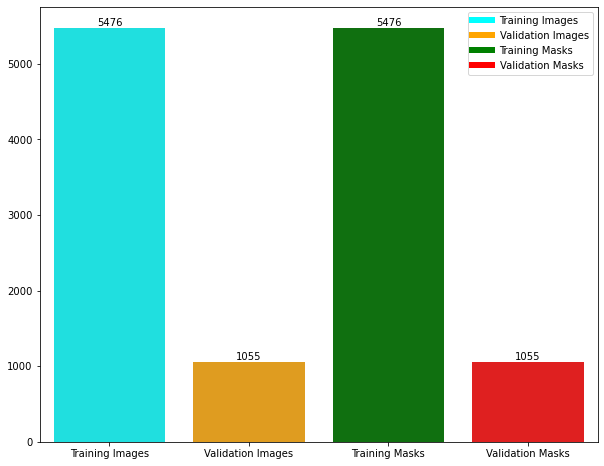

In [60]:
#plotting the list of dataset distribution
import seaborn as sn
dataset_counts = [img_training_count, img_validation_count, mask_training_count, mask_validation_count]
labels = ["Training Images", "Validation Images", "Training Masks", "Validation Masks"]
plt.figure(figsize=(10, 8))
ax = sn.barplot(x=labels, y=dataset_counts, palette=['cyan', 'orange', 'green', 'red'])
for i, count in enumerate(dataset_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')
legend_labels = ['Training Images', 'Validation Images', 'Training Masks', 'Validation Masks']
legend_handles = [plt.Line2D([0], [0], color='cyan', lw=6),
                  plt.Line2D([0], [0], color='orange', lw=6),
                  plt.Line2D([0], [0], color='green', lw=6),
                  plt.Line2D([0], [0], color='red', lw=6)]
ax.legend(legend_handles, legend_labels, loc='upper right')
plt.savefig("/data2/grp03/results/dataset_dist.png")
plt.show()